# EXEMPLO - Aula_17: Regressão Logística

Base de Dados <br>
Fonte da dados: kaglgle <br>
Link: https://www.kaggle.com/kost13/us-income-logistic-regression/data <br>
Resumo: Dados do Censo Adulto Americano referentes a renda para fatores sociais como Idade, Educação, raça, etc. <br>
Objetivo: Ajustar um modelo de regressão logística, em uma base de treinamento, para uma resposta binária, fazer a previsão desta resposta e avaliar a qualidade de ajuste do modelo em uma base de teste.


## Importando os Dados

In [73]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

columns = ['Age','Workclass','fnlgwt','Education','Education num','Marital Status',
           'Occupation','Relationship','Race','Sex','Capital Gain','Capital Loss',
           'Hours/Week','Native country','Income']

train = pd.read_csv('C:/Users/crrodr/Desktop/Tera - Data Science/Bases para exemplos-exercicios/Regressao_Logistica/Adult/adult-training.csv', names=columns)
test = pd.read_csv('C:/Users/crrodr/Desktop/Tera - Data Science/Bases para exemplos-exercicios/Regressao_Logistica/Adult/adult-test.csv', names=columns, skiprows=1)

%matplotlib inline

In [74]:
train.head()

,Age,Workclass,fnlgwt,Education,Education num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours/Week,Native country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Mais informação sobre este data set pode se encontrada em: [archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names)

In [75]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
Age               32561 non-null int64
Workclass         32561 non-null object
fnlgwt            32561 non-null int64
Education         32561 non-null object
Education num     32561 non-null int64
Marital Status    32561 non-null object
Occupation        32561 non-null object
Relationship      32561 non-null object
Race              32561 non-null object
Sex               32561 non-null object
Capital Gain      32561 non-null int64
Capital Loss      32561 non-null int64
Hours/Week        32561 non-null int64
Native country    32561 non-null object
Income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [76]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
Age               16281 non-null int64
Workclass         16281 non-null object
fnlgwt            16281 non-null int64
Education         16281 non-null object
Education num     16281 non-null int64
Marital Status    16281 non-null object
Occupation        16281 non-null object
Relationship      16281 non-null object
Race              16281 non-null object
Sex               16281 non-null object
Capital Gain      16281 non-null int64
Capital Loss      16281 non-null int64
Hours/Week        16281 non-null int64
Native country    16281 non-null object
Income            16281 non-null object
dtypes: int64(6), object(9)
memory usage: 1.9+ MB


## Limpando os dados
Algumas celulas contem ' ?' -> vamos converter para nan

In [77]:
train.replace(' ?', np.nan, inplace=True)
test.replace(' ?', np.nan, inplace=True)

In [78]:
train.isnull().sum()

Age                  0
Workclass         1836
fnlgwt               0
Education            0
Education num        0
Marital Status       0
Occupation        1843
Relationship         0
Race                 0
Sex                  0
Capital Gain         0
Capital Loss         0
Hours/Week           0
Native country     583
Income               0
dtype: int64

In [79]:
test.isnull().sum()

Age                 0
Workclass         963
fnlgwt              0
Education           0
Education num       0
Marital Status      0
Occupation        966
Relationship        0
Race                0
Sex                 0
Capital Gain        0
Capital Loss        0
Hours/Week          0
Native country    274
Income              0
dtype: int64

Como visto, somente Workclass, Occupation e Native country tem valores missing

# Parte_1: Analisando as Variáveis Input

## Income

Transformando a variável Income-Renda em 0's and 1's

In [80]:
# apply: aplica uma fç a coluna especificada - no caso Income
# defini a fç lambda (nome de variável restrita do python) e já aplica ela
train['Income'] = train['Income'].apply(lambda x: 1 if x==' >50K' else 0)
test['Income'] = test['Income'].apply(lambda x: 1 if x==' >50K.' else 0)

## Age

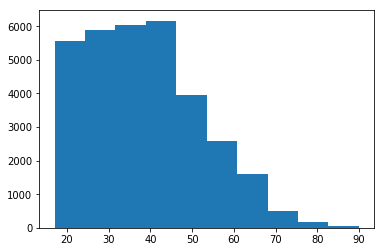

In [81]:
plt.hist(train['Age']);

A variável Age parece assimétrica, ela pode ser normalizada. 

## Workclass

Tem muitas linhas missing, então vamos colocá-las em uma nova classe, substituindo por 0 e ver como fica o gráfico

In [82]:
train['Workclass'].fillna(' 0', inplace=True)
test['Workclass'].fillna(' 0', inplace=True)

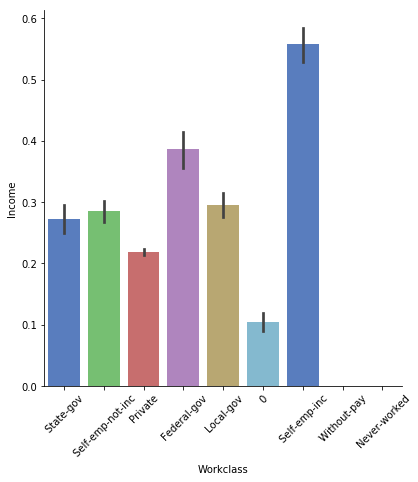

In [83]:
sns.factorplot(x="Workclass", y="Income", data=train, kind="bar", size = 6, 
palette = "muted")
plt.xticks(rotation=45);

In [84]:
train['Workclass'].value_counts()

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 0                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: Workclass, dtype: int64

As categorias Never-worked e Without-pay tem poucas obs então vamos juntá-las

In [85]:
train['Workclass'].replace(' Without-pay', ' Never-worked', inplace=True)
test['Workclass'].replace(' Without-pay', ' Never-worked', inplace=True)

## fnlgwt

In [86]:
train['fnlgwt'].describe()

count    3.256100e+04
mean     1.897784e+05
std      1.055500e+05
min      1.228500e+04
25%      1.178270e+05
50%      1.783560e+05
75%      2.370510e+05
max      1.484705e+06
Name: fnlgwt, dtype: float64

A variável Fnlwgt tem números elevados e grande desvio padrão, vamos tomar um logaritmo dela

In [87]:
# poderia usar tb train['fnlgwt'] = train['fnlgwt'].apply(np.log1p)
train['fnlgwt'] = train['fnlgwt'].apply(lambda x: np.log1p(x))
test['fnlgwt'] = test['fnlgwt'].apply(lambda x: np.log1p(x))

In [88]:
train['fnlgwt'].describe()

count    32561.000000
mean        11.983778
std          0.630738
min          9.416216
25%         11.676981
50%         12.091542
75%         12.376035
max         14.210727
Name: fnlgwt, dtype: float64

## Education

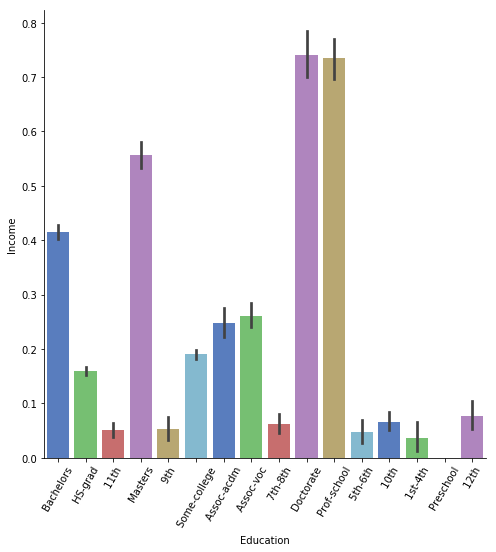

In [89]:
sns.factorplot(x="Education",y="Income",data=train,kind="bar", size = 7, 
palette = "muted")
plt.xticks(rotation=60);

A educação primária é dividada em grades:' 1st-4th', ' 5th-6th', ' 7th-8th', ' 9th', ' 10th', ' 11th', ' 12th'. <br>
Por isso vamos juntar essas classes em uma nova classe - Primary

In [90]:
def primary(x):
    if x in [' 1st-4th', ' 5th-6th', ' 7th-8th', ' 9th', ' 10th', ' 11th', ' 12th']:
        return ' Primary'
    else:
        return x

In [91]:
train['Education'] = train['Education'].apply(primary)
test['Education'] = test['Education'].apply(primary)

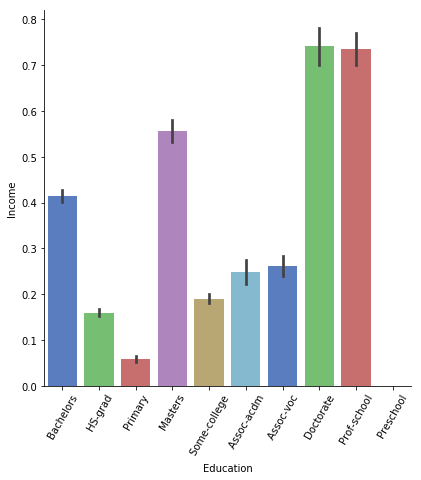

In [92]:
sns.factorplot(x="Education",y="Income",data=train,kind="bar", size = 6, 
palette = "muted")
plt.xticks(rotation=60);

## Education num

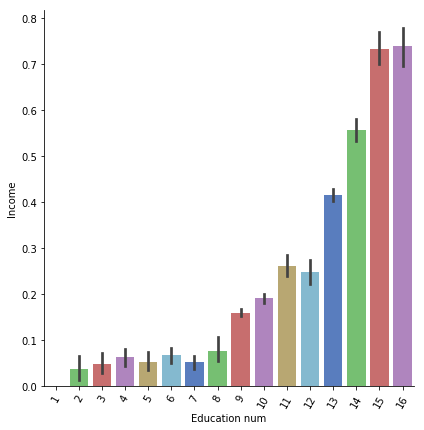

In [93]:
sns.factorplot(x="Education num",y="Income",data=train,kind="bar", size = 6, 
palette = "muted")
plt.xticks(rotation=60);

## Marital Status

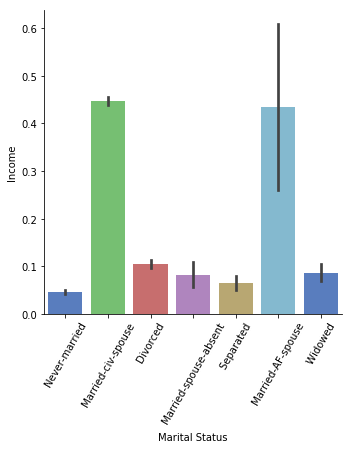

In [94]:
sns.factorplot(x="Marital Status",y="Income",data=train,kind="bar", size = 5, 
palette = "muted")
plt.xticks(rotation=60);

In [95]:
train['Marital Status'].value_counts()

 Married-civ-spouse       14976
 Never-married            10683
 Divorced                  4443
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: Marital Status, dtype: int64

Há poucas obs na categoria Married-AF-spouse. Então vamos juntá-la com a categoria Married-civ-spouse.

In [96]:
train['Marital Status'].replace(' Married-AF-spouse', ' Married-civ-spouse', inplace=True)
test['Marital Status'].replace(' Married-AF-spouse', ' Married-civ-spouse', inplace=True)

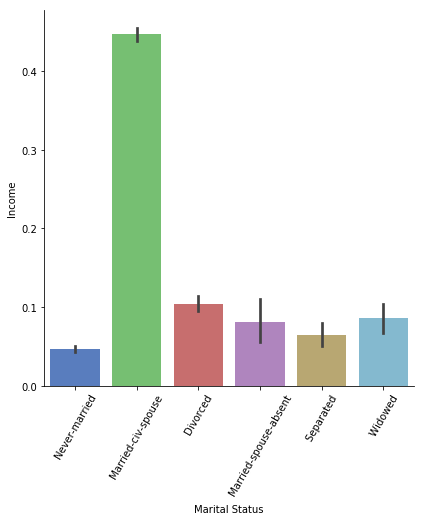

In [97]:
sns.factorplot(x="Marital Status",y="Income",data=train,kind="bar", size = 6, 
palette = "muted")
plt.xticks(rotation=60);

## Occupation

Tem muitas linhas missing, então vamos colocá-las em uma nova classe, substituindo por 0 e ver como fica o gráfico

In [98]:
train['Occupation'].fillna(' 0', inplace=True)
test['Occupation'].fillna(' 0', inplace=True)

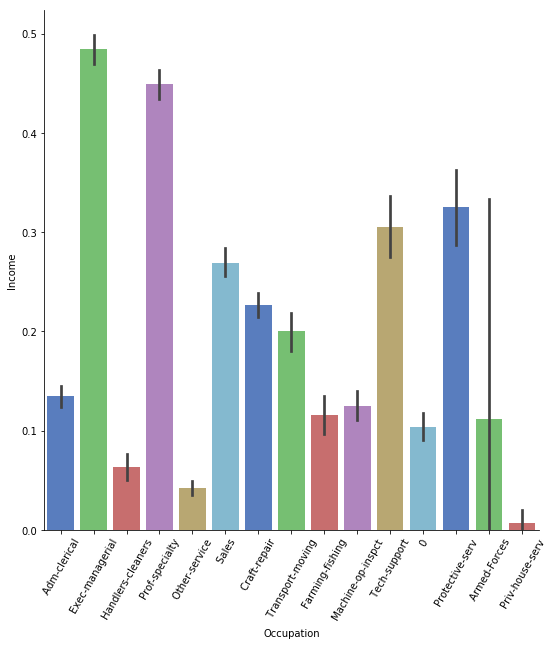

In [99]:
sns.factorplot(x="Occupation",y="Income",data=train,kind="bar", size = 8, 
palette = "muted")
plt.xticks(rotation=60);

In [100]:
train['Occupation'].value_counts()

 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3770
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 0                    1843
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
Name: Occupation, dtype: int64

A categoria Armed-Forces tem poucas observações, então vamos juntá-la com a categoria 0

In [101]:
train['Occupation'].replace(' Armed-Forces', ' 0', inplace=True)
test['Occupation'].replace(' Armed-Forces', ' 0', inplace=True)

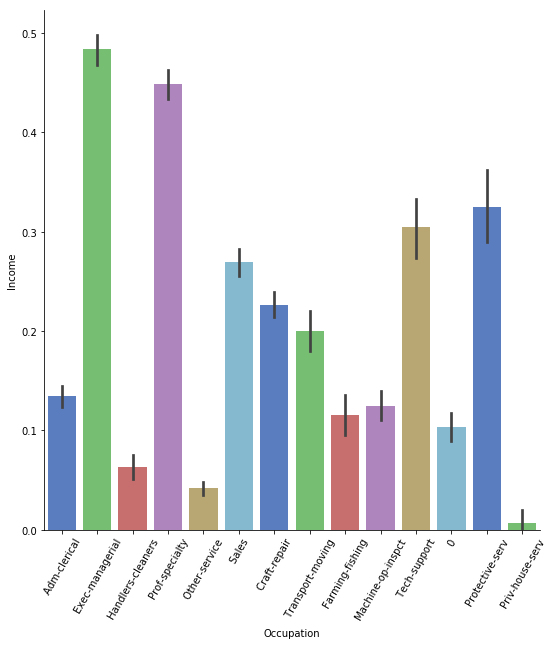

In [102]:
sns.factorplot(x="Occupation",y="Income",data=train,kind="bar", size = 8, 
palette = "muted")
plt.xticks(rotation=60);

## Relationship

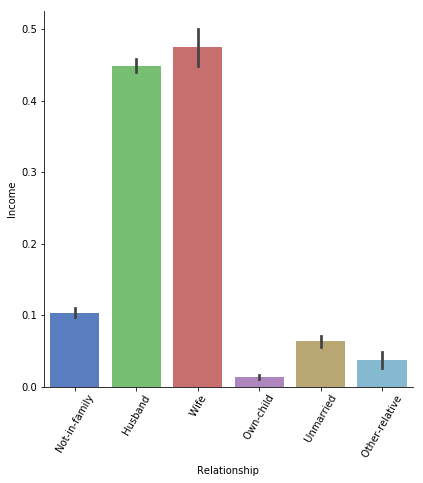

In [103]:
sns.factorplot(x="Relationship",y="Income",data=train,kind="bar", size = 6, 
palette = "muted")
plt.xticks(rotation=60);

In [104]:
train['Relationship'].value_counts()

 Husband           13193
 Not-in-family      8305
 Own-child          5068
 Unmarried          3446
 Wife               1568
 Other-relative      981
Name: Relationship, dtype: int64

Tudo OK com essa variável

## Race

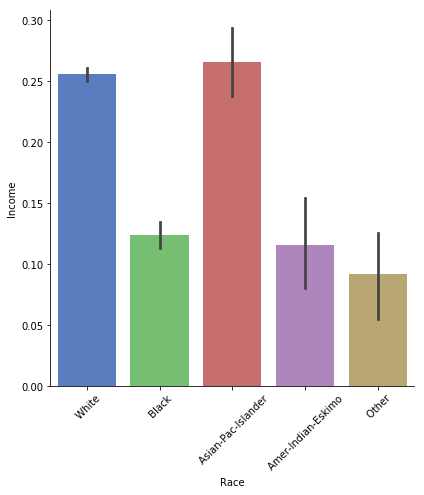

In [105]:
sns.factorplot(x="Race",y="Income",data=train,kind="bar", size = 6, 
palette = "muted")
plt.xticks(rotation=45);

In [106]:
train['Race'].value_counts()

 White                 27816
 Black                  3124
 Asian-Pac-Islander     1039
 Amer-Indian-Eskimo      311
 Other                   271
Name: Race, dtype: int64

Tudo OK com essa variável

## Sex

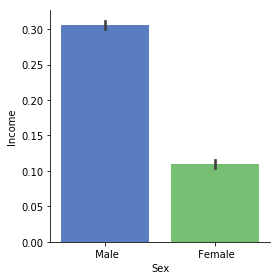

In [107]:
sns.factorplot(x="Sex",y="Income",data=train,kind="bar", size = 4, 
palette = "muted");

Tudo OK com essa variável

## Native country 

Tem algumas linhas missing, então vamos colocá-las em uma nova classe, substituindo por 0 e ver como fica o gráfico

In [108]:
train['Native country'].fillna(' 0', inplace=True)
test['Native country'].fillna(' 0', inplace=True)

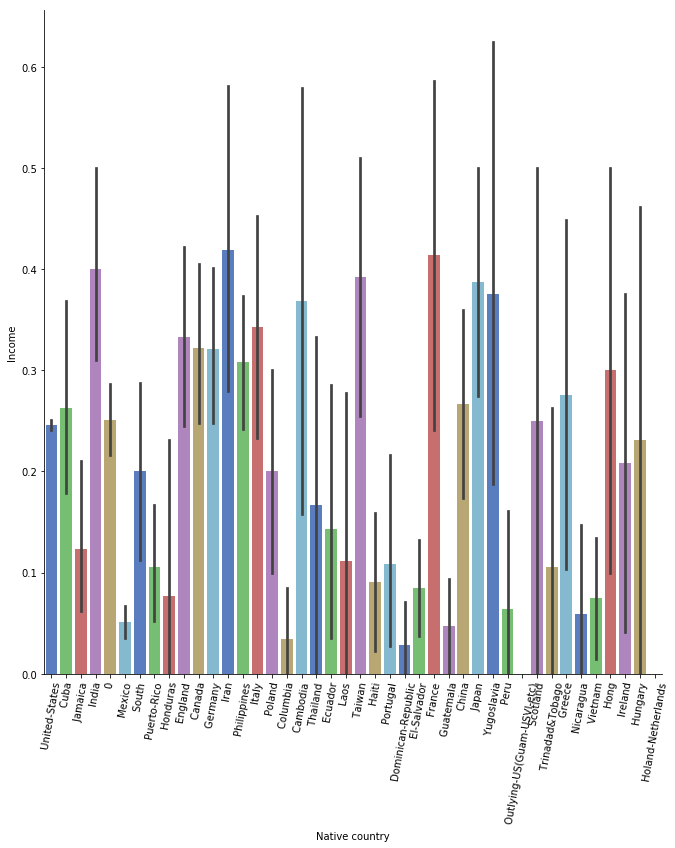

In [109]:
sns.factorplot(x="Native country",y="Income",data=train,kind="bar", size = 10, 
palette = "muted")
plt.xticks(rotation=80);

Vamos agrupar essas categorias.

In [110]:
def native(country):
    if country in [' United-States', ' Cuba', ' 0']:
        return 'US'
    elif country in [' England', ' Germany', ' Canada', ' Italy', ' France', ' Greece', ' Philippines']:
        return 'Western'
    elif country in [' Mexico', ' Puerto-Rico', ' Honduras', ' Jamaica', ' Columbia', ' Laos', ' Portugal', ' Haiti',
                     ' Dominican-Republic', ' El-Salvador', ' Guatemala', ' Peru', 
                     ' Trinadad&Tobago', ' Outlying-US(Guam-USVI-etc)', ' Nicaragua', ' Vietnam', ' Holand-Netherlands' ]:
        return 'Poor' 
    elif country in [' India', ' Iran', ' Cambodia', ' Taiwan', ' Japan', ' Yugoslavia', ' China', ' Hong']:
        return 'Eastern'
    elif country in [' South', ' Poland', ' Ireland', ' Hungary', ' Scotland', ' Thailand', ' Ecuador']:
        return 'Poland team'
    
    else: 
        return country    

In [111]:
train['Native country'] = train['Native country'].apply(native)
test['Native country'] = test['Native country'].apply(native)

In [112]:
train['Native country'].value_counts()

US             29848
Poor            1415
Western          677
Eastern          386
Poland team      235
Name: Native country, dtype: int64

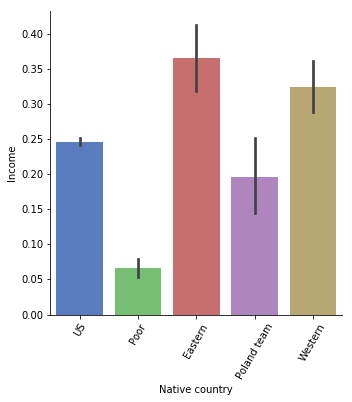

In [113]:
sns.factorplot(x="Native country",y="Income",data=train,kind="bar", size = 5, 
palette = "muted")
plt.xticks(rotation=60);

### Parte_1.1: Criando Dummys

Agora precisamos criar dummys para as variáveis categóricas usando o pd.get_dummies(). <br>
Como esse método pode causar alguns problemas, mesclarmos os conjuntos de dados. Isso garante que as dimensões para ambos os conjuntos de dados sejam iguais às dos conjuntos de dados de treinamento e teste.

In [114]:
#merge datasets
joint = pd.concat([train, test], axis=0)
# Renaming certain columns for better readability
joint = joint.rename(columns={'Education num': 'Education_num', 
                        'Marital Status': 'Marital',
                        'Capital Gain': 'Capital_Gain',
                        'Capital Loss': 'Capital_Loss',
                        'Hours/Week': 'Hours_Week',
                        'Native country': 'Country'
                                                })

In [115]:
#joint.dtypes

In [116]:
#list of columns with dtype: object
#axes[1] coluna
#axes[0] linha
categorical_features = joint.select_dtypes(include=['object']).axes[1] # retorna as vars que são do tipo objeto

# unique: retorna os valores únicos
# nunique: retorna o número de valores únicos
for col in categorical_features:
    print (col, joint[col].nunique()) # retorna as vars que são do tipo objeto e a quantidade de categorias em cada uma delas

Workclass 8
Education 10
Marital 6
Occupation 14
Relationship 6
Race 5
Sex 2
Country 5


In [117]:
#criando dummys para as variáveis categoricas
for col in categorical_features:
    joint = pd.concat([joint, pd.get_dummies(joint[col], prefix=col, prefix_sep='_')], axis=1)
    joint.drop(col, axis=1, inplace=True)

In [118]:
# renomeando as variáveis
new_columns = {}
for i in joint.columns:
    new_column = i.replace(" ", "")
    new_column = new_column.replace("-", "_")
    new_columns[i] = new_column

joint = joint.rename(columns=new_columns)

In [119]:
#joint.columns

In [120]:
joint.head()

,Age,fnlgwt,Education_num,Capital_Gain,Capital_Loss,Hours_Week,Income,Workclass_0,Workclass_Federal_gov,Workclass_Local_gov,Workclass_Never_worked,Workclass_Private,Workclass_Self_emp_inc,Workclass_Self_emp_not_inc,Workclass_State_gov,Education_Assoc_acdm,Education_Assoc_voc,Education_Bachelors,Education_Doctorate,Education_HS_grad,Education_Masters,Education_Preschool,Education_Primary,Education_Prof_school,Education_Some_college,Marital_Divorced,Marital_Married_civ_spouse,Marital_Married_spouse_absent,Marital_Never_married,Marital_Separated,Marital_Widowed,Occupation_0,Occupation_Adm_clerical,Occupation_Craft_repair,Occupation_Exec_managerial,Occupation_Farming_fishing,Occupation_Handlers_cleaners,Occupation_Machine_op_inspct,Occupation_Other_service,Occupation_Priv_house_serv,Occupation_Prof_specialty,Occupation_Protective_serv,Occupation_Sales,Occupation_Tech_support,Occupation_Transport_moving,Relationship_Husband,Relationship_Not_in_family,Relationship_Other_relative,Relationship_Own_child,Relationship_Unmarried,Relationship_Wife,Race_Amer_Indian_Eskimo,Race_Asian_Pac_Islander,Race_Black,Race_Other,Race_White,Sex_Female,Sex_Male,Country_Eastern,Country_Polandteam,Country_Poor,Country_US,Country_Western
0,39,11.258253,13,2174,0,40,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0
1,50,11.330348,13,0,0,13,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0
2,38,12.281398,9,0,0,40,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0
3,53,12.366157,7,0,0,40,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
4,28,12.732013,13,0,0,40,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0


Separando novamente a base em treinamento e teste.

In [121]:
train = joint.head(train.shape[0])
test = joint.tail(test.shape[0])

Dividindo o data frame em inputs e target

In [122]:
Xtrain = train.drop('Income', axis=1)
Ttrain = train['Income']

Xtest = test.drop('Income', axis=1)
Ttest = test['Income']

#scaler = StandardScaler()
#scaler.fit(Xtrain)
#Xtrain = scaler.transform(Xtrain)
#Xtest = scaler.transform(Xtest)

In [123]:
Xtrain.head()

,Age,fnlgwt,Education_num,Capital_Gain,Capital_Loss,Hours_Week,Workclass_0,Workclass_Federal_gov,Workclass_Local_gov,Workclass_Never_worked,Workclass_Private,Workclass_Self_emp_inc,Workclass_Self_emp_not_inc,Workclass_State_gov,Education_Assoc_acdm,Education_Assoc_voc,Education_Bachelors,Education_Doctorate,Education_HS_grad,Education_Masters,Education_Preschool,Education_Primary,Education_Prof_school,Education_Some_college,Marital_Divorced,Marital_Married_civ_spouse,Marital_Married_spouse_absent,Marital_Never_married,Marital_Separated,Marital_Widowed,Occupation_0,Occupation_Adm_clerical,Occupation_Craft_repair,Occupation_Exec_managerial,Occupation_Farming_fishing,Occupation_Handlers_cleaners,Occupation_Machine_op_inspct,Occupation_Other_service,Occupation_Priv_house_serv,Occupation_Prof_specialty,Occupation_Protective_serv,Occupation_Sales,Occupation_Tech_support,Occupation_Transport_moving,Relationship_Husband,Relationship_Not_in_family,Relationship_Other_relative,Relationship_Own_child,Relationship_Unmarried,Relationship_Wife,Race_Amer_Indian_Eskimo,Race_Asian_Pac_Islander,Race_Black,Race_Other,Race_White,Sex_Female,Sex_Male,Country_Eastern,Country_Polandteam,Country_Poor,Country_US,Country_Western
0,39,11.258253,13,2174,0,40,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0
1,50,11.330348,13,0,0,13,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0
2,38,12.281398,9,0,0,40,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0
3,53,12.366157,7,0,0,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
4,28,12.732013,13,0,0,40,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0


## Parte_2: Verificando a correlação entre as variáveis Dummy para cada var_original

In [124]:
# # matriz de correlação das variáveis Workclass
# Base_Workclass = train[[ 'Workclass_0', 'Workclass_Federal_gov',  'Workclass_Local_gov',  'Workclass_Never_worked',
#  'Workclass_Private', 'Workclass_Self_emp_inc', 'Workclass_Self_emp_not_inc', 'Workclass_State_gov','Income']]
# corr = Base_Workclass.corr()
# corr = (corr)
# sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)
# corr
# # Variáveis mais corr com a resposta Income: 'Workclass_Self_emp_inc', 'Workclass_Private', 'Workclass_0'

In [125]:
# # matriz de correlação das variáveis Education
# Base_Education = train[[  'Education_Assoc_acdm', 'Education_Assoc_voc', 'Education_Bachelors', 'Education_Doctorate',
#  'Education_HS_grad', 'Education_Masters', 'Education_Preschool', 'Education_Primary', 'Education_Prof_school',
#  'Education_Some_college','Income']]
# corr = Base_Education.corr()
# corr = (corr)
# sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)
# corr
# # Variáveis mais corr com a resposta Income: 'Education_Bachelors', 'Education_Masters', 'Education_Primary',
# #'Education_Prof_school'

,Marital_Divorced,Marital_Married_civ_spouse,Marital_Married_spouse_absent,Marital_Never_married,Marital_Separated,Marital_Widowed,Income
Marital_Divorced,1.000000,-0.367359,-0.045331,-0.277772,-0.071665,-0.070501,-0.126995
Marital_Married_civ_spouse,-0.367359,1.000000,-0.105388,-0.645784,-0.166611,-0.163906,0.445289
Marital_Married_spouse_absent,-0.045331,-0.105388,1.000000,-0.079687,-0.020559,-0.020225,-0.042532
Marital_Never_married,-0.277772,-0.645784,-0.079687,1.000000,-0.125980,-0.123935,-0.318440
Marital_Separated,-0.071665,-0.166611,-0.020559,-0.125980,1.000000,-0.031975,-0.074386
Marital_Widowed,-0.070501,-0.163906,-0.020225,-0.123935,-0.031975,1.000000,-0.064381
Income,-0.126995,0.445289,-0.042532,-0.318440,-0.074386,-0.064381,1.000000


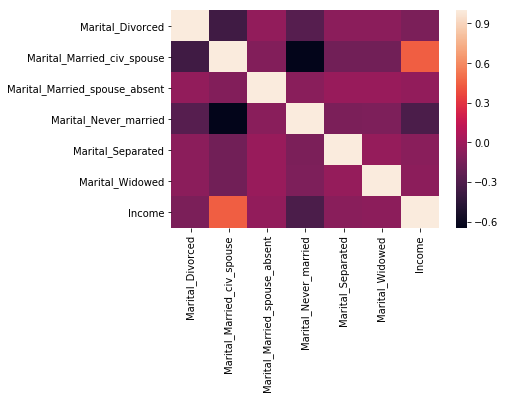

In [126]:
# matriz de correlação das variáveis Marital
Base_Marital = train[['Marital_Divorced', 'Marital_Married_civ_spouse', 'Marital_Married_spouse_absent',
 'Marital_Never_married', 'Marital_Separated', 'Marital_Widowed','Income']]
corr = Base_Marital.corr()
corr = (corr)
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)
corr
# Variáveis mais corr com a resposta Income: 'Marital_Married_civ_spouse', 'Marital_Divorced',

In [127]:
# # matriz de correlação das variáveis Occupation
# Base_Occupation = train[[ 'Occupation_0', 'Occupation_Adm_clerical', 'Occupation_Craft_repair', 'Occupation_Exec_managerial',
#  'Occupation_Farming_fishing', 'Occupation_Handlers_cleaners', 'Occupation_Machine_op_inspct', 'Occupation_Other_service',
#  'Occupation_Priv_house_serv', 'Occupation_Prof_specialty', 'Occupation_Protective_serv', 'Occupation_Sales',
#  'Occupation_Tech_support', 'Occupation_Transport_moving','Income']]
# corr = Base_Occupation.corr()
# corr = (corr)
# sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)
# corr
# # Variáveis mais corr com a resposta Income: 'Occupation_Exec_managerial', 'Occupation_Other_service','Occupation_Prof_specialty'

In [128]:
# # matriz de correlação das variáveis Relationship
# Base_Relationship = train[[ 'Relationship_Husband', 'Relationship_Not_in_family', 'Relationship_Other_relative',
#  'Relationship_Own_child', 'Relationship_Unmarried', 'Relationship_Wife','Income']]
# corr = Base_Relationship.corr()
# corr = (corr)
# sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)
# corr
# # Variáveis mais corr com a resposta Income: 'Relationship_Husband', 'Relationship_Own_child'

In [129]:
# # matriz de correlação das variáveis Sex
# Base_Race = train[[  'Race_Amer_Indian_Eskimo', 'Race_Asian_Pac_Islander', 'Race_Black',
#  'Race_Other', 'Race_White','Income']]
# corr = Base_Race.corr()
# corr = (corr)
# sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)
# corr
# # Variáveis mais corr com a resposta Income: 'Race_White'

In [130]:
# matriz de correlação das variáveis Sex
# Usar só Female - pois são complementares

In [131]:
## matriz de correlação das variáveis Country
# Base_Country = train[[ 'Country_Eastern', 'Country_Polandteam','Country_Poor','Country_US','Country_Western','Income']]
# corr = Base_Country.corr()
# corr = (corr)
# sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)
# corr
## Variáveis mais corr com a resposta Income: 'CountryPoor','CountryUS

Variáveis a serem utilizadas no método forward para seleção
    'Workclass_Self_emp_inc', 'Workclass_Private', 'Workclass_0',
    'Education_Bachelors', 'Education_Masters', 'Education_Primary','Education_Prof_school',
    'Marital_Married_civ_spouse', 'Marital_Divorced',
    'Occupation_Exec_managerial', 'Occupation_Other_service','Occupation_Prof_specialty',
    'Relationship_Husband', 'Relationship_Own_child',
    'Race_White',
    'Sex_Female',
    'CountryPoor','CountryUS'

In [132]:
#train.dtypes

## Parte_3: Metodo de seleção de variáveis forward

In [133]:
#Metodo de seleção de variáveis forward usando statsmodels
import statsmodels.formula.api as smf
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [134]:
train_1 = train[[
    'Workclass_Self_emp_inc', 'Workclass_Private', 'Workclass_0',
    'Education_Bachelors', 'Education_Masters', 'Education_Primary','Education_Prof_school',
    'Marital_Married_civ_spouse', 'Marital_Divorced',
    'Occupation_Exec_managerial', 'Occupation_Other_service','Occupation_Prof_specialty',
    'Relationship_Husband', 'Relationship_Own_child',
    'Race_White',
    'Sex_Female',
    'Country_Poor','Country_US',
    'Age','fnlgwt','Education_num','Capital_Gain','Capital_Loss','Hours_Week',
    'Income',
]]

In [135]:
#colocar para rodar quando for sair para o almoço
#aplicando o método de seleção de variáveis forward

# model = forward_selected(train_1, 'Income')
# print(model.model.formula)
# print(model.rsquared_adj)


## Parte_4: Ajustando um modelo de Regressão Logística usando sklearn

In [136]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm
import pylab as pl



In [137]:
model = LogisticRegression()
a = model.fit(Xtrain, Ttrain)

model.fit(Xtrain, Ttrain)
Ytrain = model.predict(Xtrain)
Ytest = model.predict(Xtest)


In [138]:
#a.coef_

In [139]:
# Calculando confusion matrix, AUC, precision e recall para base de treinamento
#model.fit(Xtrain, Ttrain)
cnf_matrix = confusion_matrix(Ttrain, Ytrain)
print ("\n\n ---Base de Treinamento---")
print ("\n\n ---Matriz de Confusão---")
print(cnf_matrix)

print ("\n\n ---Logistic Model---")
logit_roc_auc = roc_auc_score(Ttrain, model.predict(Xtrain))
print ("Logistic AUC = %2.2f" % logit_roc_auc)
print(classification_report(Ttrain, Ytrain))



 ---Base de Treinamento---


 ---Matriz de Confusão---
[[22980  1740]
 [ 3155  4686]]


 ---Logistic Model---
Logistic AUC = 0.76
             precision    recall  f1-score   support

          0       0.88      0.93      0.90     24720
          1       0.73      0.60      0.66      7841

avg / total       0.84      0.85      0.84     32561



In [140]:
# Calculando AUC, precision e recall para base de teste
#model.fit(Xtest, Ttest)
cnf_matrix = confusion_matrix(Ttest, Ytest)
print ("\n\n ---Base de Teste---")
print ("\n\n ---Matriz de Confusão---")
print(cnf_matrix)
print ("\n\n ---Logistic Model---")
logit_roc_auc = roc_auc_score(Ttest, model.predict(Xtest))
print ("Logistic AUC = %2.2f" % logit_roc_auc)
print(classification_report(Ttest, Ytest))



 ---Base de Teste---


 ---Matriz de Confusão---
[[11574   861]
 [ 1572  2274]]


 ---Logistic Model---
Logistic AUC = 0.76
             precision    recall  f1-score   support

          0       0.88      0.93      0.90     12435
          1       0.73      0.59      0.65      3846

avg / total       0.84      0.85      0.85     16281



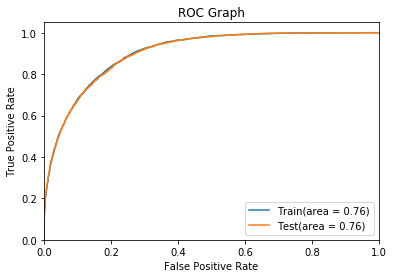

In [141]:
# Plotando o curva ROC para a base de treinamento
fpr, tpr, thresholds = roc_curve(Ttrain, model.predict_proba(Xtrain)[:,1])
# fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Train(area = %0.2f)' % logit_roc_auc)

# Plotando o curva ROC para a base de teste
fpr, tpr, thresholds = roc_curve(Ttest, model.predict_proba(Xtest)[:,1])
plt.plot(fpr, tpr, label='Test(area = %0.2f)' % logit_roc_auc)


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

## Parte_5: Ajustando um modelo de Regressão Logística usando statsmodels

In [142]:
# Modelo com variáveis obtidas do método forward
iv = ['Marital_Married_civ_spouse','Education_num','Capital_Gain','Occupation_Exec_managerial','Capital_Loss','Hours_Week',
'Age','Occupation_Prof_specialty','Education_Primary','Workclass_Self_emp_inc','Workclass_Private','Sex_Female',
'Relationship_Husband','fnlgwt','Race_White','Education_Masters','Country_Poor','Education_Prof_school',
'Occupation_Other_service','Education_Bachelors','Relationship_Own_child']

logReg = sm.Logit(Ttrain, Xtrain[iv])

#Ytrain = logReg.predict(Xtrain[iv])
#Ytest = logReg.predict(Xtest)
answer = logReg.fit()

answer.summary2()


Optimization terminated successfully.
         Current function value: 0.335338
         Iterations 9


<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: Logit
===========================================================================
Model:                  Logit               Pseudo R-squared:    0.393     
Dependent Variable:     Income              AIC:                 21879.8574
Date:                   2017-11-09 19:39    BIC:                 22056.0657
No. Observations:       32561               Log-Likelihood:      -10919.   
Df Model:               20                  LL-Null:             -17974.   
Df Residuals:           32540               LLR p-value:         0.0000    
Converged:              1.0000              Scale:               1.0000    
No. Iterations:         9.0000                                             
---------------------------------------------------------------------------
                            Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
Marital_Married_civ_spouse  2.8678   0.0775  36.9795 0.0000  2.7158  3.0197
Education_num               0.1177   0.0140   8.3956 0.0000  0.0903  0.1452
Capital_Gain                0.0003   0.0000  31.3738 0.0000  0.0003  0.0003
Occupation_Exec_managerial  0.8117   0.0481  16.8583 0.0000  0.7173  0.9061
Capital_Loss                0.0006   0.0000  18.0644 0.0000  0.0006  0.0007
Hours_Week                  0.0194   0.0015  13.3241 0.0000  0.0166  0.0223
Age                         0.0170   0.0015  11.7262 0.0000  0.0142  0.0199
Occupation_Prof_specialty   0.6222   0.0546  11.3964 0.0000  0.5152  0.7292
Education_Primary          -0.7670   0.0960  -7.9923 0.0000 -0.9550 -0.5789
Workclass_Self_emp_inc      0.4977   0.0849   5.8617 0.0000  0.3313  0.6641
Workclass_Private           0.1923   0.0387   4.9700 0.0000  0.1165  0.2682
Sex_Female                 -0.8396   0.0692 -12.1254 0.0000 -0.9754 -0.7039
Relationship_Husband       -1.0789   0.0897 -12.0253 0.0000 -1.2547 -0.9030
fnlgwt                     -0.4585   0.0139 -32.9189 0.0000 -0.4858 -0.4312
Race_White                 -0.0448   0.0541  -0.8286 0.4073 -0.1508  0.0612
Education_Masters           0.6637   0.0875   7.5874 0.0000  0.4923  0.8351
Country_Poor               -0.7648   0.1303  -5.8701 0.0000 -1.0201 -0.5094
Education_Prof_school       0.9682   0.1411   6.8604 0.0000  0.6916  1.2448
Occupation_Other_service   -0.9379   0.1008  -9.3079 0.0000 -1.1354 -0.7404
Education_Bachelors         0.4738   0.0603   7.8543 0.0000  0.3556  0.5920
Relationship_Own_child     -1.6802   0.1434 -11.7181 0.0000 -1.9613 -1.3992
===========================================================================

"""

In [143]:
# Calculando o valor predito das bases de treinamento e validação
Ytrain = answer.predict(Xtrain[iv])

fpr1, tpr1, thresholds =roc_curve(Ttrain, Ytrain)
roc_auc1 = auc(fpr1, tpr1)
print("Area under the ROC curve Tain : %f" % roc_auc1)

Ytest = answer.predict(Xtest[iv])

fpr2, tpr2, thresholds =roc_curve(Ttest, Ytest)
roc_auc2 = auc(fpr2, tpr2)
print("Area under the ROC curve Tain : %f" % roc_auc2)

Area under the ROC curve Tain : 0.894787
Area under the ROC curve Tain : 0.893805


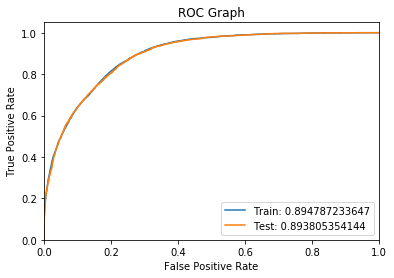

In [144]:
# plotando a curva ROC para as bases de treinamento e validação
plt.plot(fpr1, tpr1)
plt.plot(fpr2, tpr2)
plt.plot()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(["Train: " + str(roc_auc1), "Test: " + str(roc_auc2)  ],  loc="lower right")
plt.show()

Referências <br>
- https://www.kaggle.com/kost13/us-income-logistic-regression
- http://planspace.org/20150423-forward_selection_with_statsmodels/